In [1]:
import warnings
warnings.filterwarnings("ignore")

In [189]:
import pickle
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
import numpy as np
from sklearn import model_selection, preprocessing, linear_model
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%config inlinebackend.figure_format = 'svg'
%matplotlib inline

In [89]:
with open('..\..\L1\combine_df.pickle', 'rb') as f:
    combine_df=pickle.load(f)

1. Создайте мешок слов с помощью sklearn.feature_extraction.text.CountVectorizer.fit_transform(). Применим его к 'tweet_stemmed' и 'tweet_lemmatized' отдельно.
Игнорируем слова, частота которых в документе строго превышает порог 0.9 с помощью max_df.
Ограничим количество слов, попадающий в мешок, с помощью max_features = 1000.
Исключим стоп-слова с помощью stop_words='english'. 
Отобразим Bag-of-Words модель как DataFrame. columns необходимо извлечь с помощью CountVectorizer.get_feature_names().


In [83]:
count_vectorizer = CountVectorizer(max_features =1000,max_df=0.9,stop_words='english' )

In [120]:
doc_stem=re.findall('[\w]+', str(combine_df.tweet_stemmed.tolist()))
doc_lem=re.findall('[\w]+', str(combine_df.tweet_lemmatized.tolist()))

In [123]:
bag_of_words_stem=count_vectorizer.fit_transform(doc_stem)
bag_of_words_lem=count_vectorizer.fit_transform(doc_lem)

In [130]:
bag_of_words_stem=count_vectorizer.fit_transform(doc_stem)
feature_names_stem=count_vectorizer.get_feature_names()
data_stem_count=pd.DataFrame(bag_of_words_stem.toarray(), columns = feature_names_stem)

In [140]:
bag_of_words_lem=count_vectorizer.fit_transform(doc_lem)
feature_names_lem=count_vectorizer.get_feature_names()
data_lem_count=pd.DataFrame(bag_of_words_lem.toarray(), columns = feature_names_lem)

2. Создайте мешок слов с помощью sklearn.feature_extraction.text.TfidfVectorizer.fit_transform(). Применим его к 'tweet_stemmed' и 'tweet_lemmatized' отдельно.
Игнорируем слова, частота которых в документе строго превышает порог 0.9 с помощью max_df.
Ограничим количество слов, попадающий в мешок, с помощью max_features = 1000.
Исключим стоп-слова с помощью stop_words='english'.
Отобразим Bag-of-Words модель как DataFrame. columns необходимо извлечь с помощью TfidfVectorizer.get_feature_names().


In [141]:
count_vectorizer = TfidfVectorizer(max_features =1000,max_df=0.9,stop_words='english' )

In [137]:
bag_of_words_stem=count_vectorizer.fit_transform(doc_stem)
bag_of_words_lem=count_vectorizer.fit_transform(doc_lem)

In [138]:
bag_of_words_stem=count_vectorizer.fit_transform(doc_stem)
feature_names_stem=count_vectorizer.get_feature_names()
data_stem_tfidf=pd.DataFrame(bag_of_words_stem.toarray(), columns = feature_names_stem)

In [142]:
bag_of_words_lem=count_vectorizer.fit_transform(doc_lem)
feature_names_lem=count_vectorizer.get_feature_names()
data_lem_tfidf=pd.DataFrame(bag_of_words_lem.toarray(), columns = feature_names_lem)

3. Проверьте ваши векторайзеры на корпусе который использовали на вебинаре, составьте таблицу метод векторизации и скор который вы получили (в методах векторизации по изменяйте параметры что бы добиться лучшего скора) обратите внимание как падает/растёт скор при уменьшении количества фичей, и изменении параметров, так же 

In [145]:
# Загружаем данные
data = open('corpus').read()
labels, texts = [], []
for i, line in enumerate(data.split("\n")):
    content = line.split()
    labels.append(content[0])
    texts.append(" ".join(content[1:]))

# создаем df
trainDF = pd.DataFrame()
trainDF['text'] = texts
trainDF['label'] = labels
trainDF.head(5)

,text,label
0,Stuning even for the non-gamer: This sound tra...,__label__2
1,The best soundtrack ever to anything.: I'm rea...,__label__2
2,Amazing!: This soundtrack is my favorite music...,__label__2
3,Excellent Soundtrack: I truly like this soundt...,__label__2
4,"Remember, Pull Your Jaw Off The Floor After He...",__label__2


In [168]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(trainDF['text'], trainDF['label'])
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)


In [208]:
count_vect = CountVectorizer(analyzer='word',max_features=2000,max_df=0.9,token_pattern=r'\w{1,}')
tfidf_vect = TfidfVectorizer(analyzer='word',max_features=2000,max_df=0.9,token_pattern=r'\w{1,}')

In [196]:
def make_score(vect):
    
    xtrain_count =  vect.transform(train_x)
    xvalid_count =  vect.transform(valid_x)
    classifier = linear_model.LogisticRegression()
    classifier.fit(xtrain_count, train_y)
    predictions = classifier.predict(xvalid_count)
    score=accuracy_score(valid_y, predictions)
    
    return score

In [211]:
def eval_param(par, means):
    
    count_scores=[]
    tfidf_scores=[]
    params=[]

    for i in means:
    
        param={par:i}

        count_vect.set_params(**param)
        tfidf_vect.set_params(**param)

        count_vect.fit(trainDF['text'])
        tfidf_vect.fit(trainDF['text'])

        count_score=make_score(count_vect)
        tfidf_score=make_score(tfidf_vect)

        count_scores.append(count_score)
        tfidf_scores.append(tfidf_score)
        params.append(i)
        
    table=pd.DataFrame({'count':count_scores, 'tfidf':tfidf_scores}, index=params)    
    
    plt.plot(params, count_scores, label='count')
    plt.plot(params, tfidf_scores, label='tfidf')
    plt.title(par)
    plt.legend()
    plt.show()
    
    return table

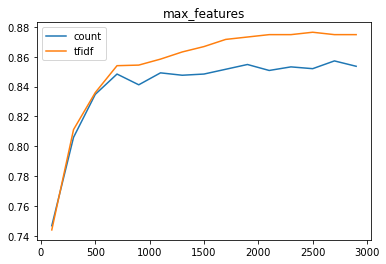

In [212]:
max_features_table=eval_param('max_features', range(100, 3000, 200))

In [215]:
# После 1500 оба векторайзера выходят на плато

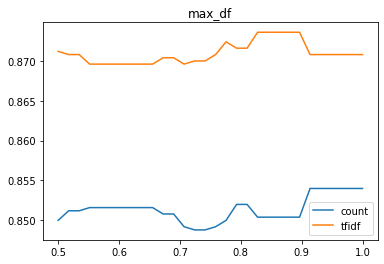

In [206]:
max_df_table=eval_param('max_df', np.linspace(0.5, 1, 30))

In [ ]:
# У tfidf максимум достигается в интервале (0.8, 0.9), у count - после 0.9

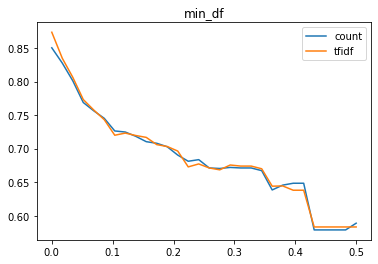

In [209]:
min_df_table=eval_param('min_df', np.linspace(0.5, 0, 30))

In [ ]:
# тут нечего комментировать

In [213]:
max_features_table.head()

,count,tfidf
100,0.7468,0.7440
300,0.8060,0.8112
500,0.8348,0.8360
700,0.8484,0.8540
900,0.8412,0.8544


In [216]:
# В целом у tfidf показатели повыше